# Exploiting the nested sampling

In [1]:
import orsa
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

sns.set(style = 'white')
mpl.rc('xtick.minor', visible = True)
mpl.rc('ytick.minor', visible = True)
mpl.rc('xtick', direction='in', top=True, bottom = True)
mpl.rc('ytick', direction='in', right=True, left = True)

print(orsa.__version__)

0.7.1


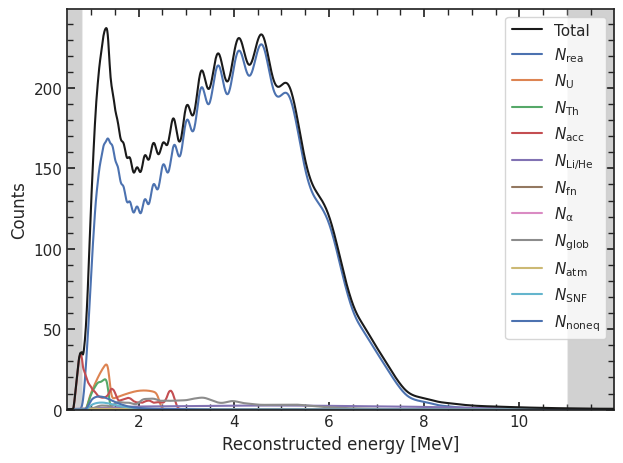

In [2]:
model = orsa.model.read_json('inputs/test_model.json')
model.exposure = 6*365.25
model

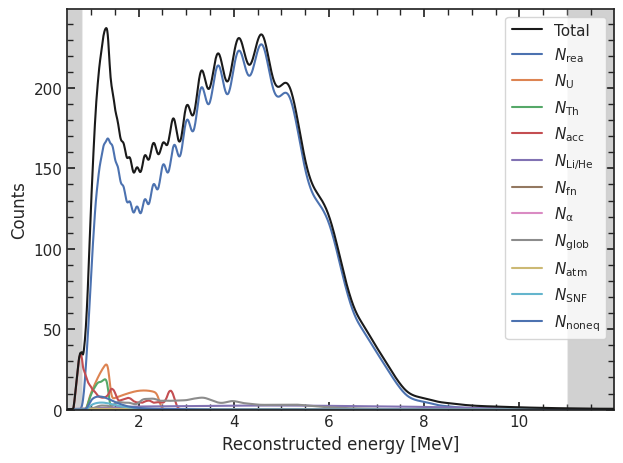

In [3]:
model

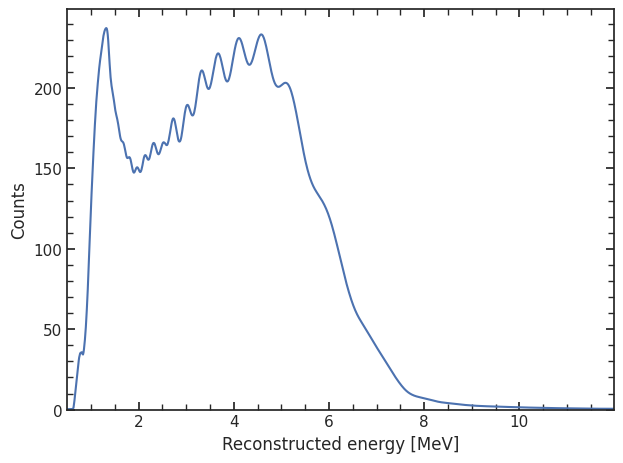

In [4]:
data = model.get_spectrum(asimov = True)
data

In [5]:
for param in model.detector_parameters:
    model.detector_parameters[param].fixed = True

for param in model.core_parameters:
    model.core_parameters[param].fixed = True

for param in model.normalization_parameters:
    if model.normalization_parameters[param].label != 'rea':
        model.normalization_parameters[param].fixed = True

model.parameters['rho'].fixed = True

In [6]:
init_model = model.copy()
min_func_bin = orsa.probability.CostFunction(ll=orsa.probability.chi2, ll_args=dict(data=data), lp_args=model.get_priors())
model.use_shape_uncertainty = False
res = orsa.fit.minuit(model, min_func_bin)

Cost function parsed as chi2-like


In [7]:
for param in model.parameters:
    if param not in min_func_bin.lp_args:
        min_func_bin.add_prior(param, 'flat', dict(left = model.parameters[param].value - 5*res.obj.errors[param], right = model.parameters[param].value + 5*res.obj.errors[param]))
    elif len(min_func_bin.lp_args[param]) > 1:
        del min_func_bin.lp_args[param]['positive']
        print('Remove prior for', param)
min_func_bin

Remove prior for eff
Remove prior for a
Remove prior for b
Remove prior for c
Remove prior for rho
Remove prior for YJ-C1
Remove prior for YJ-C2
Remove prior for YJ-C3
Remove prior for YJ-C4
Remove prior for YJ-C5
Remove prior for YJ-C6
Remove prior for TS-C1
Remove prior for TS-C2
Remove prior for DYB-C
Remove prior for rea
Remove prior for U
Remove prior for Th
Remove prior for acc
Remove prior for lihe
Remove prior for fn
Remove prior for alpha
Remove prior for glob
Remove prior for atm
Remove prior for snf
Remove prior for noneq


In [8]:
m_nested = orsa.fit.dynesty(model, min_func_bin, 1000)

Cost function parsed as chi2-like


0it [00:00, ?it/s]